File built on the mechanics file

In [1]:
import requests
from lxml import etree
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import time
import sqlite3

In [2]:
con = sqlite3.connect('bgg.db')
cur = con.cursor()

In [11]:
query = '''
 SELECT t1.id, title, CAST(avg_rating AS FLOAT64) avg_rating, CAST(avg_bayes_rating AS FLOAT64),
        CAST(std as FLOAT64) std, category
 
 FROM TOP_GAMES_FULL t1
   LEFT JOIN BGG_CATEGORIES t2
     ON t1.id = t2.id
     
ORDER BY avg_rating DESC
'''

results = cur.execute(query)
result_li = [elem for elem in results.fetchall()]

In [12]:
df = pd.DataFrame(result_li, columns = ['id', 'Title','Score', 'BayesScore', 'StdDev', 'Category'])

In [13]:
pivot = pd.pivot_table(data=df, index='Category', values = ['id'], aggfunc='count')
pivot.columns = ['Games']
pivot.sort_values('Games', ascending=False,inplace=True)
pivot.head(10)

,Games
Category,
Card Game,246
Fantasy,210
Economic,200
Fighting,156
Science Fiction,130
Adventure,109
Wargame,102
Miniatures,97
Exploration,94


In [14]:
pivot.tail(5)

,Games
Category,
Electronic,3
Trivia,2
American Revolutionary War,2
Vietnam War,1
Expansion for Base-game,1


In [22]:
unpopular_cat_li = list(pivot[pivot['Games'] < 30].index)

In [24]:
# What are the top economic games?
df[df.Category == 'Economic'].head(10)

,id,Title,Score,BayesScore,StdDev,Category
30,284378,kanban_ev,8.70048,7.24979,1.20878,Economic
33,233078,twilight_imperium_fourth_edition,8.68469,8.25446,1.59933,Economic
40,224517,brass_birmingham,8.66929,8.40600,1.24659,Economic
61,220308,gaia_project,8.48599,8.17700,1.38992,Economic
79,167791,terraforming_mars,8.42470,8.27852,1.38438,Economic
87,182028,through_ages_new_story_civilization,8.40041,8.16310,1.50896,Economic
95,256960,pax_pamir_second_edition,8.38845,7.68404,1.41854,Economic
105,256916,concordia_venus,8.36289,7.29527,1.20657,Economic
134,193738,great_western_trail,8.30257,8.12938,1.26217,Economic
142,184267,mars,8.28442,7.69571,1.48998,Economic


In [30]:
# Remove unpopular categories
df = df[~df['Category'].isin(unpopular_cat_li)]

In [31]:
cat_popularity = pd.pivot_table(df, index='Category',values='Score', aggfunc =['count','mean'])

In [32]:
cat_popularity.sort_values(('mean', 'Score'), ascending=False, inplace=True)
cat_popularity.head(10)

,count,mean
,Score,Score
Category,,
Wargame,102,7.744096
Space Exploration,35,7.736283
Miniatures,97,7.727345
Industry / Manufacturing,48,7.716122
Political,51,7.699332
Science Fiction,130,7.614947
Economic,200,7.613747
Adventure,109,7.610351


In [34]:
std_pivot = pd.pivot_table(df, index='Category', values =['Score'], aggfunc=['mean', 'std', 'count'])
std_pivot.sort_values(('mean', 'Score'), ascending=False)

,mean,std,count
,Score,Score,Score
Category,,,
Wargame,7.744096,0.359506,102
Space Exploration,7.736283,0.406687,35
Miniatures,7.727345,0.437759,97
Industry / Manufacturing,7.716122,0.421021,48
Political,7.699332,0.393972,51
Science Fiction,7.614947,0.412592,130
Economic,7.613747,0.373531,200
Adventure,7.610351,0.490190,109


Given the lack of variability for scores, let's test to see if there is a difference between the first and last score

In [35]:
from scipy.stats import ttest_ind

In [36]:
best_mechanic = df.loc[df['Category'] == 'Wargame', 'Score']

In [38]:
worst_mechanic = df.loc[df['Category'] == 'Party Game', 'Score']

In [39]:
ttest_ind(a=best_mechanic, b=worst_mechanic,equal_var=False)

Ttest_indResult(statistic=8.590847584285903, pvalue=1.3198776705344143e-13)

Pretty clearly significant. Side 

In [131]:
# This will be a list of mechanics I like. They are not chosen for statistical purposes
mechanic_li = ['Worker Placement', 'Tile Placement', 'Solo / Solitaire Game', 'Dice Rolling', 'Set Collection']

In [132]:
five_mechanics = df[df['Mechanic'].isin(mechanic_li)]

In [133]:
import seaborn as sns

In [134]:
sns.set(rc={'figure.figsize':(10,8)})

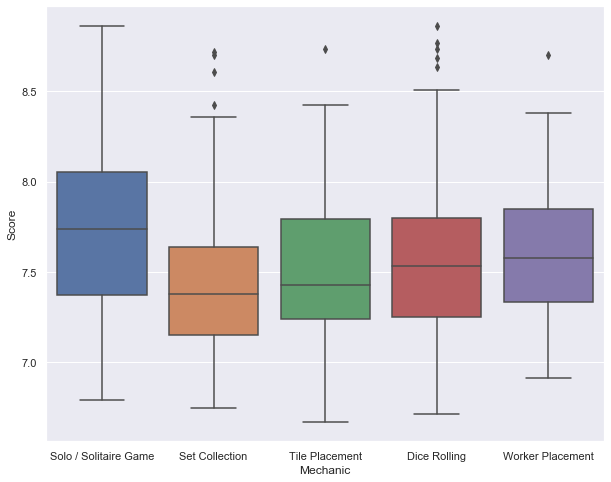

In [135]:
sns.boxplot(data=five_mechanics,x='Mechanic',y='Score')

Let's see if there's a stistically significant difference. Barplot will work for this, but we'll have a lot of wasted space since all the values are at least 7. Let's subtract 7 from all the scores

In [136]:
five_mechanics['NewScore'] = five_mechanics['Score'].apply(lambda x: x-7)

C:\Users\18053\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


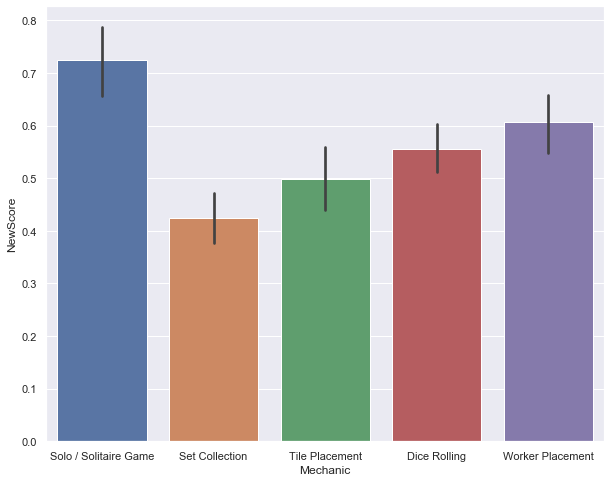

In [137]:
sns.barplot(data=five_mechanics,x='Mechanic',y='NewScore')

Looks like Solo's score is statistically siginifically higher than Set Colleciton, Tile Placement, and Dice Rolling. Eyeballing it, it's hard to tell for Worker Placement. 

Let's look at the 10% level. First, let's sort smallest to largest so it's easier to read

In [138]:
def sort_mechanic(mechanic):
    mechanic_li = ['Worker Placement', 'Tile Placement', 'Solo / Solitaire Game', 'Dice Rolling', 'Set Collection']
    if mechanic == 'Solo / Solitaire Game':
        return 0
    elif mechanic == 'Worker Placement':
        return 1
    elif mechanic == 'Dice Rolling':
        return 2
    elif mechanic == 'Tile Placement':
        return 3
    else:
        return 4

In [139]:
five_mechanics['SortValue'] = five_mechanics['Mechanic'].apply(sort_mechanic)
five_mechanics.sort_values('SortValue',ascending=True,inplace=True)

C:\Users\18053\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\18053\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


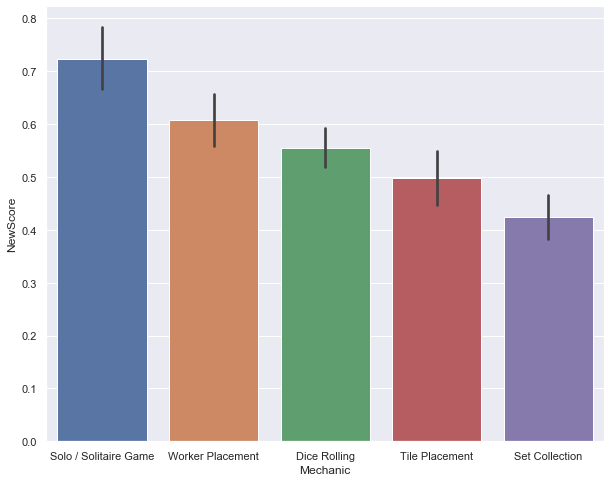

In [140]:
sns.barplot(data=five_mechanics,x='Mechanic',y='NewScore',ci=90)

Close for Solo & Worker Placement, and close for Worker Placement & Tile Placement. Overall though, Solo clearly does better than the bottom three, and set collection performs worse than the top 3

What about the standard deviation? Are some mechanics more divisive?

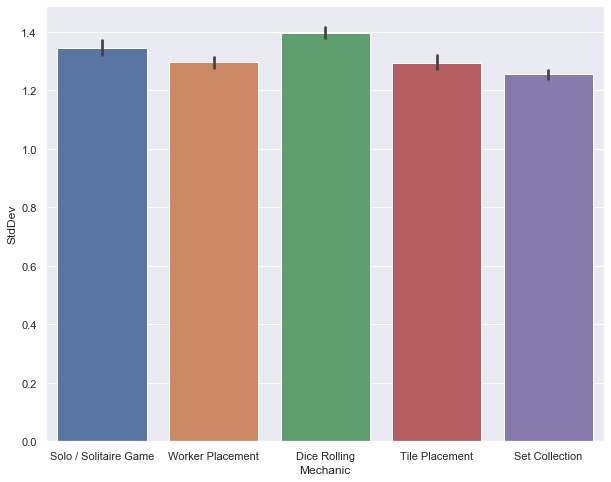

In [141]:
sns.barplot(data=five_mechanics,x='Mechanic',y='StdDev',ci=95)

Changing the axis could really change the story here. Let's subtract one from standard deviation and look again

In [142]:
# Looks like I don't need to use apply/lamba here, I wanted to try both ways
five_mechanics['NewStdDev'] = five_mechanics['StdDev'] - 1 

C:\Users\18053\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


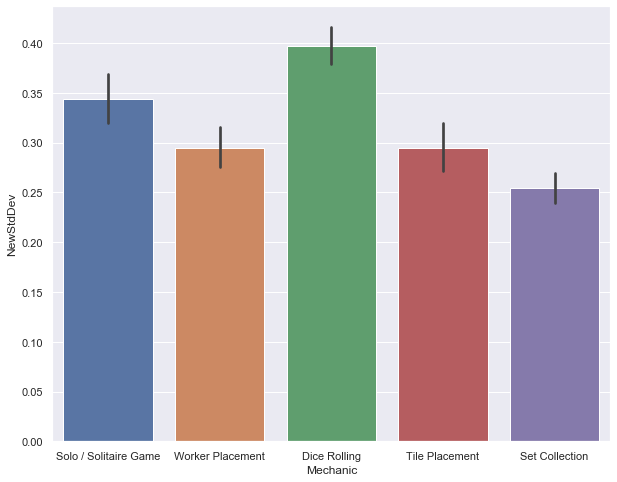

In [143]:
sns.barplot(data=five_mechanics,x='Mechanic',y='NewStdDev',ci=95)

Dice Rolling is more divisive! This makes intuitive sense to me, as it could be used in various different types of games. On the other hand, Worker Placement is generally only used in more 'hardcore' Euro games. 

...however, we have to consider the effect size. Is 0.2 points in standard deviation pratictally meaningful? Hard to say. This could be like "nudges" in behavioural economics: statistically significant but practically quite small. 